<a href="https://colab.research.google.com/github/feliavila/Trabajos/blob/main/CursoPython_TPfinal_An%C3%A1lisis_de_base_de_datos_de_propiedades_moleculas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#descargar rdkit
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 10.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#1.Importamos las librerías a utilizar.
import pandas as pd
import rdkit

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Leemos el archivo en pandas

archivo= pd.read_csv("/content/drive/MyDrive/Curso Python/Trabajo final Curso Phyton/Delaney.csv",index_col=0)
archivo.head(n=10)  #vemos las diez primeras filas del dataframe

#index_col=0, para no generar una columna con las etiquetas del index.

,SMILES,Compound ID
0,ClCC(Cl)(Cl)Cl,"1,1,1,2-Tetrachloroethane"
1,CC(Cl)(Cl)Cl,"1,1,1-Trichloroethane"
2,ClC(Cl)C(Cl)Cl,"1,1,2,2-Tetrachloroethane"
3,ClCC(Cl)Cl,"1,1,2-Trichloroethane"
4,FC(F)(Cl)C(F)(Cl)Cl,"1,1,2-Trichlorotrifluoroethane"
5,CC(Cl)Cl,"1,1-Dichloroethane"
6,ClC(=C)Cl,"1,1-Dichloroethylene"
7,CCOC(C)OCC,"1,1-Diethoxyethane"
8,Clc1ccc(Cl)c(Cl)c1Cl,"1,2,3,4-Tetrachlorobenzene"
9,C1CCc2ccccc2C1,"1,2,3,4-Tetrahydronapthalene"


In [ ]:
#Analisis de valores faltantes
archivo.isna().sum()

SMILES         0
Compound ID    0
dtype: int64

**No hay valores faltantes (na)**

In [ ]:
#Analisis de duplicados:

archivo.nunique()

SMILES         1128
Compound ID    1143
dtype: int64

In [ ]:
#Analisis de duplicados:
duplicados= archivo[archivo["SMILES"].duplicated()]
print(duplicados)

                                              SMILES            Compound ID
152                      Clc1ccc(cc1)c2cccc(Cl)c2Cl              2,3,4'-PCB
167                      Clc1ccc(cc1)c2cc(Cl)ccc2Cl              2,4',5-PCB
182                          Clc1ccc(cc1)c2ccccc2Cl                 2,4-PCB
289                                        CCC(C)CCO    3-Methyl-2-pentanol
509                       CN(C)C(=O)Nc1ccc(C)c(Cl)c1           Chlortoluron
628   ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl                 Endrin
649                CCOC2Oc1ccc(OS(C)(=O)=O)cc1C2(C)C           ethofumesate
668                              CCOC(=O)c1ccc(N)cc1  Ethyl-p-aminobenzoate
696                    CN(C)C(=O)Nc1cccc(c1)C(F)(F)F          Fluorometuron
781          OCC1OC(OC2C(O)C(O)C(O)OC2CO)C(O)C(O)C1O                Maltose
870     CCN(CC)c1c(cc(c(N)c1N(=O)=O)C(F)(F)F)N(=O)=O              Nitramine
912              ClC(Cl)=C(c1ccc(Cl)cc1)c2ccc(Cl)cc2               P,P'-DDE
916         

**Hay algunos errores en el dataframe: existen estructuras SMILES asociadas a dos nombres diferentes. Se debería revisar para encontrar la nomenclatura correcta**

In [ ]:
duplicados= archivo[archivo["Compound ID"].duplicated()]
print(duplicados)

        SMILES          Compound ID
289  CCC(C)CCO  3-Methyl-2-pentanol


**Existe una fila duplicada, que podría eliminarse empleando el método  'drop_duplicates()'.**

In [ ]:
#2. Cálculo de propiedades moleculares con RDKi. SE DEBEN AGREGAR AL DATASET LAS SIGUIENTES PROPIEDADES:

#cLogP (Octanol-water partition coefficient): Este coeficiente indica la lipofilicidad de una molécula, es decir, su afinidad relativa por la fase orgánica o acuosa.
#MW (Molecular weight): El peso molecular de una molécula es la suma de las masas atómicas de todos los átomos en la molécula.
# RB (Number of rotatable bonds): Los enlaces rotativos son aquellos que pueden girar libremente alrededor de su eje, lo que influye en la flexibilidad de la molécula.
#AP (Aromatic proportion): La proporción aromática indica la cantidad de átomos aromáticos en relación con el total de átomos pesados en la molécula.


#definimos las funciones para cada parámetro,
#que se aplican sobre la estructura SMILES:
def calclogP(smiles):
    molecula = Chem.MolFromSmiles(smiles)
    return Descriptors.MolLogP(molecula)

def calcMW(smiles):
    molecula = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(molecula)

def calcRB(smiles):
    molecula = Chem.MolFromSmiles(smiles)
    return Descriptors.NumRotatableBonds(molecula)

def calcAP(smiles):
    molecula = Chem.MolFromSmiles(smiles)
    cant_atomos= Descriptors.HeavyAtomCount(molecula)
    cant_aromaticos= Descriptors.NumAromaticRings(molecula)
    return cant_aromaticos/cant_atomos

#aplicamos las funciones a los valores de la serie SMILES, y
#generamos nuevas columnas con los datos obtenidos
archivo['clogP'] = archivo['SMILES'].apply(calclogP)
archivo['MW'] = archivo['SMILES'].apply(calcMW)
archivo['RB'] = archivo['SMILES'].apply(calcRB)
archivo['AP'] = archivo['SMILES'].apply(calcAP)

archivo.head(n=10) #para ver cómo quedó el df modificado.

,SMILES,Compound ID,clogP,MW,RB,AP
0,ClCC(Cl)(Cl)Cl,"1,1,1,2-Tetrachloroethane",2.5954,167.850,0,0.0
1,CC(Cl)(Cl)Cl,"1,1,1-Trichloroethane",2.3765,133.405,0,0.0
2,ClC(Cl)C(Cl)Cl,"1,1,2,2-Tetrachloroethane",2.5938,167.850,1,0.0
3,ClCC(Cl)Cl,"1,1,2-Trichloroethane",2.0289,133.405,1,0.0
4,FC(F)(Cl)C(F)(Cl)Cl,"1,1,2-Trichlorotrifluoroethane",2.9189,187.375,1,0.0
5,CC(Cl)Cl,"1,1-Dichloroethane",1.8100,98.960,0,0.0
6,ClC(=C)Cl,"1,1-Dichloroethylene",1.9352,96.944,0,0.0
7,CCOC(C)OCC,"1,1-Diethoxyethane",1.4054,118.176,4,0.0
8,Clc1ccc(Cl)c(Cl)c1Cl,"1,2,3,4-Tetrachlorobenzene",4.3002,215.894,0,0.1
9,C1CCc2ccccc2C1,"1,2,3,4-Tetrahydronapthalene",2.5654,132.206,0,0.1


In [ ]:
archivo.info()  #para confirmar la creación de las nuevas columnas

<class 'pandas.core.frame.DataFrame'>
Index: 1144 entries, 0 to 1143
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SMILES       1144 non-null   object 
 1   Compound ID  1144 non-null   object 
 2   clogP        1144 non-null   float64
 3   MW           1144 non-null   float64
 4   RB           1144 non-null   int64  
 5   AP           1144 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 62.6+ KB


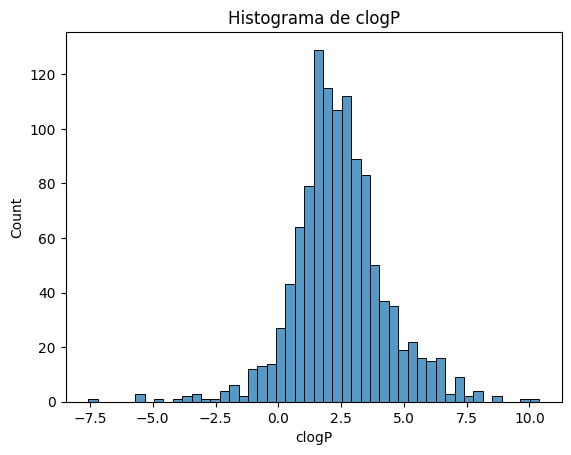

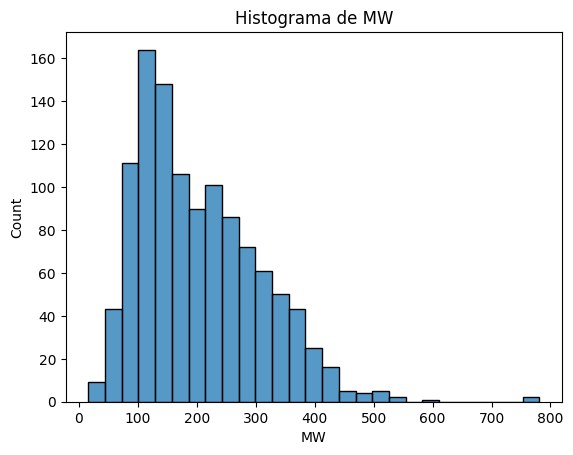

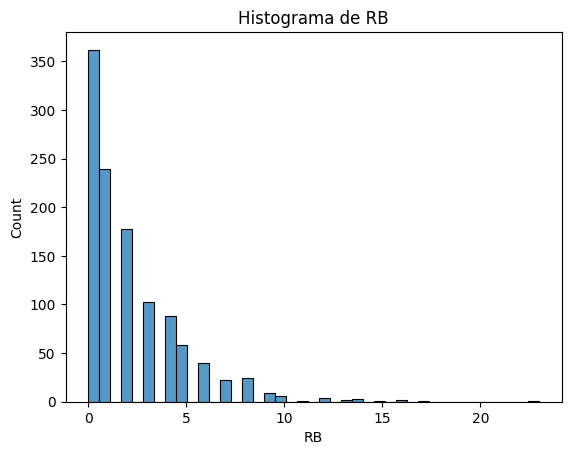

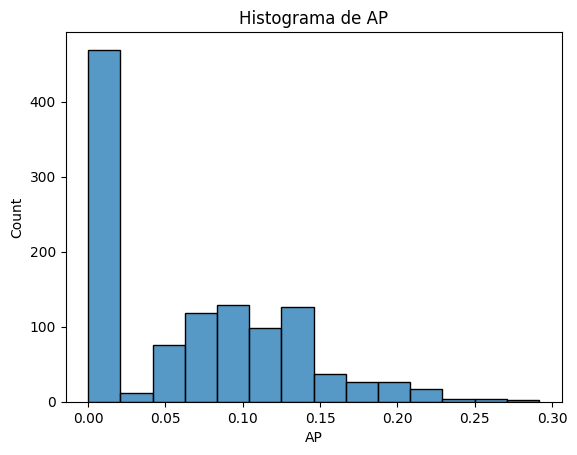

In [ ]:
#3. Histogramas para cada propiedad calculada (clogP, MW, RB, AP)
#Emplee estadística descriptiva para comprender el dataframe.

#Identifique posibles outliers en los datos.

#Según los valores máximo y mínimos de MW, clasificarlos en 3 grupos MW_bajo, MW_medio y MW_alto.

# Para cada grupo grafique las distribuciones de MW.
# Seleccione una molécula al azar de cada grupo y genere la visualización molecular.
# Crear un histograma para cada columna de descriptores excepto las excluidas
columnas_excluidas = ['SMILES', 'Compound ID']
for columna in archivo.columns:
    if columna not in columnas_excluidas:
        sns.histplot(data=archivo, x=columna)
        plt.title(f'Histograma de {columna}')
        plt.show()



In [ ]:
#Estadistica Descriptiva
#Método describe() revisa las estadisticas descriptivas de la columna
for columna in archivo.columns:
    if columna not in columnas_excluidas:
      print("estadística descriptiva de",{columna},":",archivo[columna].describe())

estadística descriptiva de {'clogP'} : count    1144.000000
mean        2.449133
std         1.866003
min        -7.571400
25%         1.414900
50%         2.340300
75%         3.406475
max        10.388600
Name: clogP, dtype: float64
estadística descriptiva de {'MW'} : count    1144.000000
mean      204.631675
std       102.620500
min        16.043000
25%       122.126000
50%       183.594500
75%       270.715750
max       780.949000
Name: MW, dtype: float64
estadística descriptiva de {'RB'} : count    1144.000000
mean        2.173951
std         2.627398
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        23.000000
Name: RB, dtype: float64
estadística descriptiva de {'AP'} : count    1144.000000
mean        0.065205
std         0.064899
min         0.000000
25%         0.000000
50%         0.062500
75%         0.111111
max         0.291667
Name: AP, dtype: float64


In [ ]:
# Filtrado simple: las filas donde el valor de clogP es menor a la media menos 3 veces la desviación estándar
archivo[archivo['clogP'] < (archivo["clogP"].mean()-3*archivo["clogP"].std())]

,SMILES,Compound ID,clogP,MW,RB,AP
379,C1(=O)NC(=O)NC(=O)C1(O)C2(O)C(=O)NC(=O)NC2(=O),alloxantin,-4.8194,286.156,1,0.0
609,OC1C(O)C(O)C(O)C(O)C1O,d-inositol,-3.8346,180.156,0,0.0
703,OCC1OC(O)(CO)C(O)C1O,Fructose,-3.2198,180.156,2,0.0
708,OCC1OC(O)C(O)C(O)C1O,glucose,-3.2214,180.156,1,0.0
771,OCC1OC(OC2C(O)C(O)C(O)OC2CO)C(O)C(O)C1O,Lactose,-5.3972,342.297,4,0.0
781,OCC1OC(OC2C(O)C(O)C(O)OC2CO)C(O)C(O)C1O,Maltose,-5.3972,342.297,4,0.0
782,OCC(O)C(O)C(O)C(O)CO,mannitol,-3.5854,182.172,5,0.0
1021,OCC1OC(CO)(OC2OC(COC3OC(CO)C(O)C(O)C3O)C(O)C(O...,Raffinose,-7.5714,504.438,8,0.0
1056,OCC(O)C(O)C(O)C(O)CO,Sorbitol,-3.5854,182.172,5,0.0
1065,OCC2OC(OC1(CO)OC(CO)C(O)C1O)C(O)C(O)C2O,Sucrose,-5.3956,342.297,5,0.0


In [ ]:
# Filtrado simple: las filas donde el valor de clogP es mayor a la media más 3 veces la desviación estándar
archivo[archivo['clogP'] > (archivo["clogP"].mean()+3*archivo["clogP"].std())]

,SMILES,Compound ID,clogP,MW,RB,AP
116,Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)c2c(Cl)c(Cl)c(Cl)c(C...,"2,2',3,3',4,4',5,5',6,6'-PCB",9.8876,498.662,1,0.090909
117,Clc1cc(c(Cl)c(Cl)c1Cl)c2cc(Cl)c(Cl)c(Cl)c2Cl,"2,2',3,3',4,4',5,5'-PCB",8.5808,429.772,1,0.100000
119,Clc1cc(Cl)c(Cl)c(c1Cl)c2c(Cl)c(Cl)cc(Cl)c2Cl,"2,2',3,3',5,5',6,6'-PCB",8.5808,429.772,1,0.100000
627,CCCCCCCCCCCCCCCCCCCC,Eicosane,8.0480,282.556,17,0.000000
721,CCCCCCCCCCCCCCCCCCCCCCCCCC,hexacosane,10.3886,366.718,23,0.000000


In [ ]:
# Filtrado simple: las filas donde el valor de MW es mayor a la media más 3 veces la desviación estándar
archivo[archivo['MW'] >(archivo["MW"].mean()+3*archivo["MW"].std())]

,SMILES,Compound ID,clogP,MW,RB,AP
444,OC(CC(c1ccccc1)c3c(O)c2ccccc2oc3=O)c4ccc(cc4)c...,bromadiolone,7.1837,527.414,6,0.142857
592,CC1OC(CC(O)C1O)OC2C(O)CC(OC2C)OC8C(O)CC(OC7CCC...,Digitoxin,3.2473,764.950,7,0.000000
593,CC1OC(CC(O)C1O)OC2C(O)CC(OC2C)OC8C(O)CC(OC7CCC...,"Digoxin (L1=41,8mg/mL, L2=68,2mg/mL, Z=40,1mg/mL)",2.2181,780.949,7,0.000000
673,COc1cc(cc(OC)c1O)C6C2C(COC2=O)C(OC4OC3COC(C)OC...,"Etoposide (148-167,25mg/ml)",1.3386,588.562,5,0.047619
843,ClC1(C2(Cl)C3(Cl)C4(Cl)C5(Cl)C1(Cl)C3(Cl)Cl)C5...,Mirex,6.2230,545.546,0,0.000000


In [ ]:
# Filtrado simple: las filas donde el valor de MW es menor a la media menos 3 veces la desviación estándar
archivo[archivo['MW'] <(archivo["MW"].mean()-3*archivo["MW"].std())]

,SMILES,Compound ID,clogP,MW,RB,AP


In [ ]:
# Filtrado simple: las filas donde el valor de RB es menor a la media menos 3 veces la desviación estándar
archivo[archivo['RB'] <(archivo["RB"].mean()-3*archivo["RB"].std())]

,SMILES,Compound ID,clogP,MW,RB,AP


In [ ]:
# Filtrado simple: las filas donde el valor de RB es mayor a la media más 3 veces la desviación estándar
archivo[archivo['RB'] >(archivo["RB"].mean()+3*archivo["RB"].std())]

,SMILES,Compound ID,clogP,MW,RB,AP
84,CCCCCCCCCCCCCCCCO,1-Hexadecanol,5.4600,242.447,14,0.000000
105,CCCCCCCCCCCCCCCCCCO,1-Octadecanol,6.2402,270.501,16,0.000000
109,CCCCCCCCCCCCCCCO,1-Pentadecanol,5.0699,228.420,13,0.000000
115,CCCCCCCCCCCCCCO,1-Tetradecanol,4.6798,214.393,12,0.000000
558,CCCCSP(=O)(SCCCC)SCCCC,DEF,6.6944,314.522,12,0.000000
566,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC,Di(2-ethylhexyl)-phthalate,6.4330,390.564,14,0.035714
576,CCCCOC(=O)CCCCCCCCC(=O)OCCCC,dibutyl sebacate,4.7938,314.466,15,0.000000
594,CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCC,Dihexyl phthalate,5.1608,334.456,12,0.041667
596,c1(C(=O)OCCCCCC(C)(C))c(C(=O)OCCCCCC(C)(C))cccc1,diisooctyl phthalate,6.4330,390.564,14,0.035714
611,CCCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCC,dioctyl phthalate,6.7212,390.564,16,0.035714


\Con el filtrado, lo que podemos ver son valores que estan muy en los limites de cada propiedad, por ejemplo, un valor OUTLIER para la propiedad "clogP" puede ser el de Raffinose	(-7.5714), ya que esta muy por debajo del resto. Podria ser en el otro extremo 2,2',3,3',4,4',5,5',6,6'-PCB	(9.8876), ya que esta bastante por arriba de la mayoria de los valores.

En otras propiedades:
MW: Los que poseen un valor mayor a 600, como lo son:
Digitoxin (764.950)
Digoxin (780.949)

RB: Los que poseen un valor mayor a 16:
Eicosane (17)
Hexacosane (23)



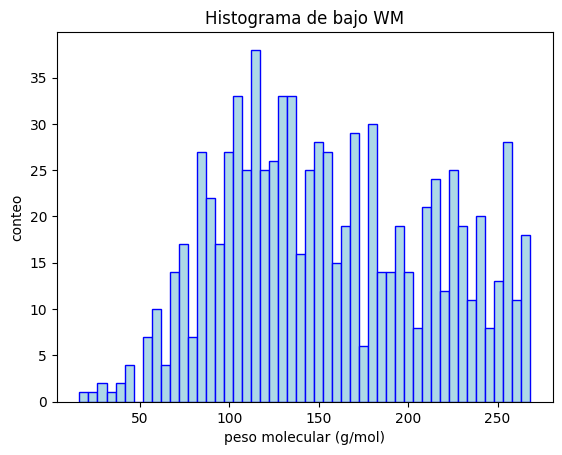

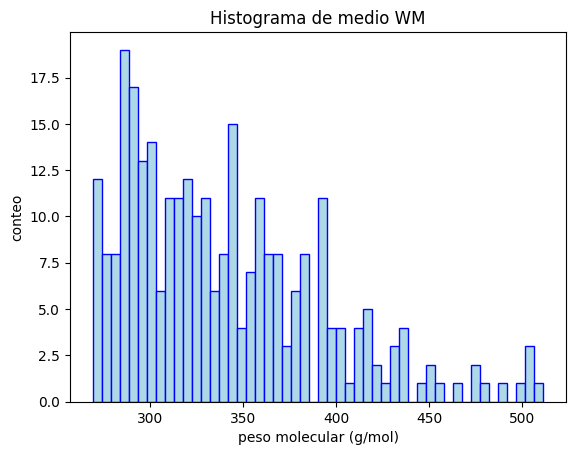

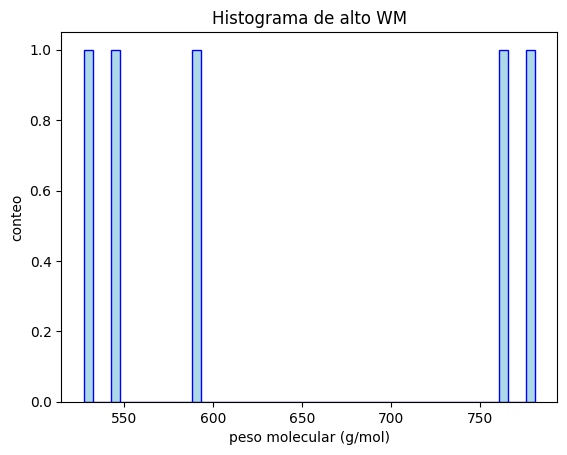

In [ ]:
#Clasificación del MW en tres grupos:
valores_MW = archivo.MW.max()-archivo.MW.min()
MW_bajo=[]
MW_medio=[]
MW_alto=[]

for mw in archivo['MW']:

   if mw < (archivo['MW'].min() + valores_MW*0.33):
      MW_bajo.append(mw)
   elif (archivo['MW'].min() + valores_MW * 0.33) <= mw < (archivo['MW'].min() + valores_MW * 0.66):
      MW_medio.append(mw)
   elif mw >= (archivo['MW'].min() + valores_MW * 0.66):
      MW_alto.append(mw)
# Ubicación de los datos en tres listas.
# Distribución de los datos de cada una de las listas:
plt.hist(MW_bajo, bins=50, color='lightblue', edgecolor='blue')
plt.title(f'Histograma de bajo WM')
plt.xlabel("peso molecular (g/mol)")
plt.ylabel("conteo")
plt.show()

plt.hist(MW_medio, bins=50, color='lightblue', edgecolor='blue')
plt.title(f'Histograma de medio WM')
plt.xlabel("peso molecular (g/mol)")
plt.ylabel("conteo")
plt.show()

plt.hist(MW_alto, bins=50, color='lightblue', edgecolor='blue')
plt.title(f'Histograma de alto WM')
plt.xlabel("peso molecular (g/mol)")
plt.ylabel("conteo")
plt.show()

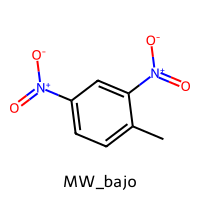

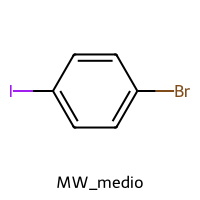

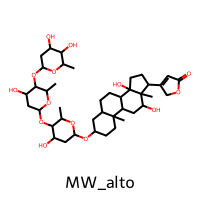

In [ ]:
# Relacionar los MW con el nombre SMILES de cada molécula

smile_b = archivo.loc[archivo['MW'].isin(MW_bajo), 'SMILES'].tolist()
smile_m = archivo.loc[archivo['MW'].isin(MW_medio), 'SMILES'].tolist()
smile_a = archivo.loc[archivo['MW'].isin(MW_alto), 'SMILES'].tolist()

import random

# Dibujar el objeto Mol en forma de imagen
img_b = Draw.MolToImage(Chem.MolFromSmiles(random.choice(smile_b)), legend=('MW_bajo'), size=(200, 200))
img_m = Draw.MolToImage(Chem.MolFromSmiles(random.choice(smile_m)), legend=('MW_medio'), size=(200, 200))
img_a = Draw.MolToImage(Chem.MolFromSmiles(random.choice(smile_a)), legend=('MW_alto'), size=(200, 200))
# Mostrar la imagen
display(img_b,img_m,img_a)

In [ ]:
archivo.to_excel("tfphyton.xlsx",index=False)

ruta_excel= "tfphyton.xlsx"

ruta_drive="/content/drive/MyDrive/Curso Python/Trabajo final Curso Phyton"

import shutil
shutil.copy(ruta_excel, ruta_drive)

'/content/drive/MyDrive/Curso Python/Trabajo final Curso Phyton/tfphyton.xlsx'